In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row, SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType,IntegerType, StringType, BooleanType
import re

In [2]:
sc = SparkContext('local')
sqlCtx = SQLContext( sc )

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# 읽기

In [3]:
df = sqlCtx.read.csv('data/mapo_cafe.csv', encoding='cp949',
                     header = True, inferSchema=True)

In [4]:
df.show()

+----------+-----------------------------------+----------------------------------+--------------------------------+------+----+
|    업종명|                             업소명|                    소재지(도로명)|                    소재지(지번)|업태명| _c5|
+----------+-----------------------------------+----------------------------------+--------------------------------+------+----+
|휴게음식점|     (주)보나비아티제상암드림타워점| 서울특별시 마포구 월드컵북로56...| 서울특별시 마포구 상암동 159...|커피숍|null|
|휴게음식점|    (주)스타벅스커피코리아 망원역점|  서울특별시 마포구 월드컵로 74...| 서울특별시 마포구 서교동 475...|커피숍|null|
|휴게음식점|      (주)엘에스씨푸드 마포구청카페|  서울특별시 마포구 월드컵로 21...| 서울특별시 마포구 성산동 370...|커피숍|null|
|휴게음식점|            (주)영우 홍익대학교매점|  서울특별시 마포구 와우산로 94...|  서울특별시 마포구 상수동 72-1 |커피숍|null|
|휴게음식점|         (주)영우홍익대학교카페나무|  서울특별시 마포구 와우산로 94...| 서울특별시 마포구 상수동 72-...|커피숍|null|
|휴게음식점|                   (주)잠두봉더나인| 서울특별시 마포구 마포나루길 5...| 서울특별시 마포구 합정동 352...|커피숍|null|
|휴게음식점|          (주)커피빈코리아 상수역점| 서울특별시 마포구 와우산로10길...| 서울특별시 마포구 상수동 143...|커피숍|null|
|휴게음식점|(주)커피빈코리아상암SBS미디어센터점|  서

In [5]:
df.count()

898

In [6]:
df.select(F.col("업태명")).drop_duplicates().show()

+------+
|업태명|
+------+
|커피숍|
+------+



In [7]:
df.select(F.col("업종명")).drop_duplicates().show()

+----------+
|    업종명|
+----------+
|휴게음식점|
+----------+



# UDF - 전처리

### 도로명 주소와 지번 주소가 육안으로는 빈 것으로 보임
1. where(F.col("도로명") != "")
2. where(F.col("도로명").isNotNull())

둘 다 위의 케이스로 걸러지지 않아서
정규표현식으로 전처리를 하기 위해 UDF를 사용했다.

In [8]:
alphanumeric = re.compile(r"[0-9ㄱ-ㅎ가-힣A-Za-z]") # 정규식

# udf1
@F.udf(returnType=BooleanType())
def udf_filter_null(x):
    if re.search(alphanumeric, x):
        return True
    else:
        return False

# udf2
@F.udf(returnType=StringType())
def split_ro(x):
    return x.split()[2]

# udf3
@F.udf(returnType=StringType())
def split_dong(x):
    return x.split()[2]

In [9]:
new_df = df.select(
    F.col("업소명"),
    F.col("소재지(도로명)").alias("도로명"),
    F.col("소재지(지번)").alias("지번")
).where(udf_filter_null(F.col("업소명"))) # udf1 사용

new_df.show()

+-----------------------------------+----------------------------------+--------------------------------+
|                             업소명|                            도로명|                            지번|
+-----------------------------------+----------------------------------+--------------------------------+
|     (주)보나비아티제상암드림타워점| 서울특별시 마포구 월드컵북로56...| 서울특별시 마포구 상암동 159...|
|    (주)스타벅스커피코리아 망원역점|  서울특별시 마포구 월드컵로 74...| 서울특별시 마포구 서교동 475...|
|      (주)엘에스씨푸드 마포구청카페|  서울특별시 마포구 월드컵로 21...| 서울특별시 마포구 성산동 370...|
|            (주)영우 홍익대학교매점|  서울특별시 마포구 와우산로 94...|  서울특별시 마포구 상수동 72-1 |
|         (주)영우홍익대학교카페나무|  서울특별시 마포구 와우산로 94...| 서울특별시 마포구 상수동 72-...|
|                   (주)잠두봉더나인| 서울특별시 마포구 마포나루길 5...| 서울특별시 마포구 합정동 352...|
|          (주)커피빈코리아 상수역점| 서울특별시 마포구 와우산로10길...| 서울특별시 마포구 상수동 143...|
|(주)커피빈코리아상암SBS미디어센터점|  서울특별시 마포구 상암산로 82...| 서울특별시 마포구 상암동 160...|
|    (주)커피빈코리아홍대역8번출구점| 서울특별시 마포구 양화로18안길...| 서울특별시 마포구 동교동 168-4 |
|                  (주)하우 신촌역점| 서울특별시 마포구 신촌로 지하 ...|서울특별시

In [10]:
new_df.count() # 변동이 있나 확인

898

In [11]:
df_street = new_df.where(
    udf_filter_null(F.col("도로명")) # udf1 사용
).select("업소명", "도로명")

df_lot = new_df.where(
    udf_filter_null(F.col("지번")) # udf1 사용
).select("업소명", "지번")

In [12]:
df_street.count()

894

In [13]:
df_lot.count()

897

In [14]:
udf_df_street = df_street.select(
                    split_ro(F.col("도로명")).alias("도로명(로)") # udf2 사용
                    )
udf_df_street.show()

+--------------+
|    도로명(로)|
+--------------+
|월드컵북로56길|
|      월드컵로|
|      월드컵로|
|      와우산로|
|      와우산로|
|    마포나루길|
|  와우산로10길|
|      상암산로|
|  양화로18안길|
|        신촌로|
|    하늘공원로|
|        백범로|
|      희우정로|
|   월드컵로3길|
|    신촌로16길|
|  월드컵로13길|
|와우산로29가길|
| 월드컵북로4길|
|     양화로6길|
|        홍익로|
+--------------+
only showing top 20 rows



# 집계

In [15]:
# groupby 및 count aggregation(집계)

agg_df_street = udf_df_street.groupBy("도로명(로)").agg(
    F.count(F.col("도로명(로)")).alias("count")).orderBy(F.col("count").desc())

agg_df_street.show()

+--------------+-----+
|    도로명(로)|count|
+--------------+-----+
|    월드컵북로|   50|
|      마포대로|   40|
|        양화로|   35|
|      월드컵로|   24|
|        백범로|   23|
|        동교로|   21|
|      와우산로|   20|
|      성미산로|   19|
|        독막로|   17|
|        토정로|   15|
|    어울마당로|   15|
|        성암로|   15|
|        포은로|   13|
|   월드컵로3길|   12|
|      잔다리로|   10|
|        신촌로|    9|
|  와우산로29길|    9|
|월드컵북로54길|    9|
|        서강로|    8|
|      매봉산로|    8|
+--------------+-----+
only showing top 20 rows



In [16]:
# 지번주소 처리 (동만 추출) - udf 사용 split_dong

udf_df_lot = df_lot.select(
                split_dong(F.col("지번")).alias("지번(동)") # udf3 사용
                )
udf_df_lot.show()

+--------+
|지번(동)|
+--------+
|  상암동|
|  서교동|
|  성산동|
|  상수동|
|  상수동|
|  합정동|
|  상수동|
|  상암동|
|  동교동|
|노고산동|
|  상암동|
|신공덕동|
|  망원동|
|  합정동|
|노고산동|
|  망원동|
|  서교동|
|  동교동|
|  서교동|
|  동교동|
+--------+
only showing top 20 rows



In [17]:
# groupby 및 count aggregation(집계)

agg_df_lot = udf_df_lot.groupBy("지번(동)").agg(
    F.count(F.col("지번(동)")).alias("count")).orderBy(F.col("count").desc())

agg_df_lot.show()

+--------+-----+
|지번(동)|count|
+--------+-----+
|  서교동|  174|
|  상암동|   98|
|  연남동|   92|
|  망원동|   84|
|  동교동|   68|
|  합정동|   64|
|  도화동|   45|
|  성산동|   43|
|  공덕동|   36|
|  신수동|   30|
|  염리동|   27|
|  상수동|   25|
|노고산동|   24|
|  대흥동|   21|
|  아현동|   20|
|  창전동|   14|
|신공덕동|   11|
|  용강동|    9|
|    중동|    5|
|  구수동|    3|
+--------+-----+
only showing top 20 rows



## 지번 주소-상위 10군데

In [18]:
# 지번주소가 데이터가 조금 더 밀집 돼 있음. -> 이를 사용
# 상위 10개

top10_agg_df_lot = agg_df_lot.limit(10)
top10_agg_df_lot.show()

+--------+-----+
|지번(동)|count|
+--------+-----+
|  서교동|  174|
|  상암동|   98|
|  연남동|   92|
|  망원동|   84|
|  동교동|   68|
|  합정동|   64|
|  도화동|   45|
|  성산동|   43|
|  공덕동|   36|
|  신수동|   30|
+--------+-----+



In [19]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
from matplotlib import rc

font_location = "./font/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_location)

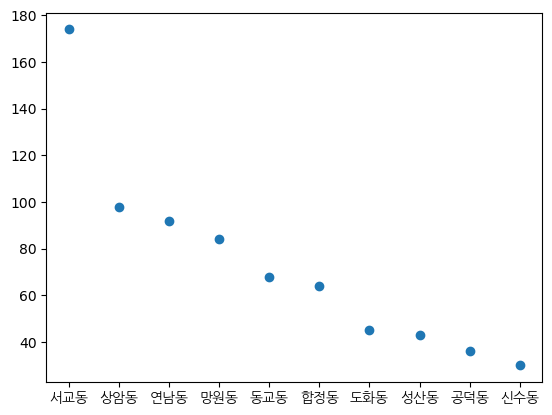

In [20]:
pdlot = top10_agg_df_lot.toPandas()
plt.scatter(pdlot['지번(동)'],pdlot['count'])
plt.xticks(fontproperties=font_prop)
plt.show()

# + EXTRA 도로명 주소도 한 번 해보기!

In [21]:
agg_df_street.show()

+--------------+-----+
|    도로명(로)|count|
+--------------+-----+
|    월드컵북로|   50|
|      마포대로|   40|
|        양화로|   35|
|      월드컵로|   24|
|        백범로|   23|
|        동교로|   21|
|      와우산로|   20|
|      성미산로|   19|
|        독막로|   17|
|        토정로|   15|
|    어울마당로|   15|
|        성암로|   15|
|        포은로|   13|
|   월드컵로3길|   12|
|      잔다리로|   10|
|        신촌로|    9|
|  와우산로29길|    9|
|월드컵북로54길|    9|
|        서강로|    8|
|      매봉산로|    8|
+--------------+-----+
only showing top 20 rows



In [22]:
# 상위 10군데
top10_agg_df_street = agg_df_street.limit(10)
top10_agg_df_street.show()

+----------+-----+
|도로명(로)|count|
+----------+-----+
|월드컵북로|   50|
|  마포대로|   40|
|    양화로|   35|
|  월드컵로|   24|
|    백범로|   23|
|    동교로|   21|
|  와우산로|   20|
|  성미산로|   19|
|    독막로|   17|
|어울마당로|   15|
+----------+-----+



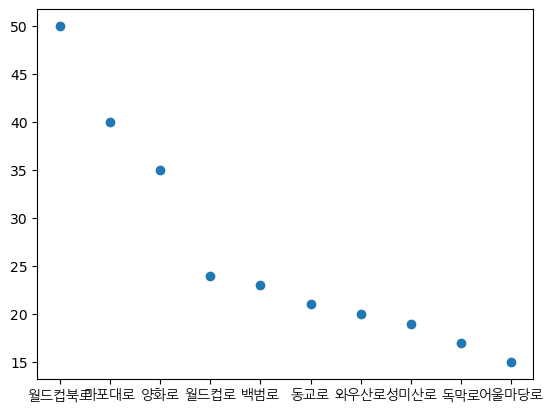

In [23]:
# 겹치는 문제 발생
pdstreet = top10_agg_df_street.toPandas()
plt.scatter(pdstreet['도로명(로)'],pdstreet['count'])
plt.xticks(fontproperties=font_prop)
plt.show()

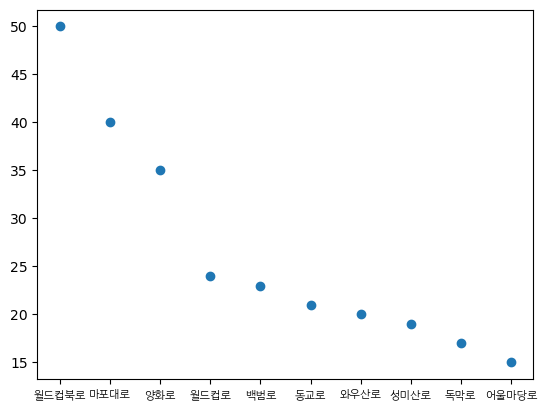

In [24]:
pdstreet = top10_agg_df_street.toPandas()
plt.scatter(pdstreet['도로명(로)'],pdstreet['count'])
plt.xticks(fontproperties=font_prop, fontsize = 8) # fontsize 설정!
plt.show()